# Requirements

In [ ]:
! git clone https://github.com/mohsenfayyaz/DecompX.git
! pip install datasets
! pip install plotly
! pip install -U kaleido
! pip install openpyxl

In [1]:
# MOHSEN
import os
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv()
login(os.environ["HF_TOKEN"])
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 2 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [ ]:
# ALI
import os
os.chdir('/mounts/Users/cisintern/amodaresi/Projects/Retriever-Contextualization/')
# from dotenv import load_dotenv
from huggingface_hub import login

# load_dotenv()
login(os.environ["HF_TOKEN"])
# print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Load Dataset

In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
import transformers
from transformers import AutoTokenizer, AutoConfig

from DecompX.src.decompx_utils import DecompXConfig
from DecompX.src.modeling_bert import BertForSequenceClassification, BertModel
from DecompX.src.modeling_roberta import RobertaForSequenceClassification, RobertaModel


df_raw = pd.read_pickle("hf://datasets/Retriever-Contextualization/datasets/nq/facebook--contriever-msmarco_corpus2681468.pkl")
df_raw

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10
0,test0,what is non controlling interest on balance sheet,"[doc0, doc1]","{'doc0': {'text': 'In accounting, minority int...","{'len': 1000, 'max': 0.7094563841819763, 'min'...","{'doc0': 0.6976445317268372, 'doc1': 0.6396652...","{'doc1457694': 0.7094563841819763, 'doc0': 0.6...",{'doc1457694': {'text': 'Non-current assets (F...
1,test1,how many episodes are in chicago fire season 4,[doc6],{'doc6': {'text': 'The fourth season of Chicag...,"{'len': 1000, 'max': 0.8498302698135376, 'min'...",{'doc6': 0.8000180721282959},"{'doc2007818': 0.8498302698135376, 'doc1977618...","{'doc2007818': {'text': 'As of April 12, 2018..."
2,test2,who sings love will keep us alive by the eagles,[doc10],"{'doc10': {'text': '""Love Will Keep Us Alive"" ...","{'len': 1000, 'max': 0.799416184425354, 'min':...",{'doc10': 0.7933686375617981},"{'doc12': 0.799416184425354, 'doc10': 0.793368...",{'doc12': {'text': 'Aside from being on the al...
3,test3,who is the leader of the ontario pc party,"[doc17, doc18]",{'doc17': {'text': 'Patrick Walter Brown MPP (...,"{'len': 1000, 'max': 0.7469745874404907, 'min'...","{'doc17': 0.6641683578491211, 'doc18': 0.71368...","{'doc1906464': 0.7469745874404907, 'doc1426217...",{'doc1906464': {'text': 'The Leader of the Off...
4,test4,nitty gritty dirt band fishin in the dark album,[doc42],"{'doc42': {'text': '""Fishin' in the Dark"" is a...","{'len': 1000, 'max': 0.7535380721092224, 'min'...",{'doc42': 0.7535380721092224},"{'doc42': 0.7535380721092224, 'doc44': 0.73443...","{'doc42': {'text': '""Fishin' in the Dark"" is a..."
...,...,...,...,...,...,...,...,...
3447,test3447,when is the met office leaving the bbc,[doc117531],"{'doc117531': {'text': 'On 23 August 2015, the...","{'len': 1000, 'max': 0.7772744297981262, 'min'...",{'doc117531': 0.7772744297981262},"{'doc117531': 0.7772744297981262, 'doc117548':...","{'doc117531': {'text': 'On 23 August 2015, the..."
3448,test3448,where does junior want to go to find hope,[doc117567],"{'doc117567': {'text': 'Throughout the novel, ...","{'len': 1000, 'max': 0.5255041718482971, 'min'...",{'doc117567': 0.5255041718482971},"{'doc117567': 0.5255041718482971, 'doc1136289'...","{'doc117567': {'text': 'Throughout the novel, ..."
3449,test3449,who does eric end up with in that 70s show,"[doc117643, doc117646]",{'doc117643': {'text': 'Regretting it instantl...,"{'len': 1000, 'max': 0.6573498249053955, 'min'...","{'doc117643': 0.5081062912940979, 'doc117646':...","{'doc332148': 0.6573498249053955, 'doc559025':...",{'doc332148': {'text': 'The eighth and final s...
3450,test3450,where does the great outdoors movie take place,"[doc117662, doc117663]",{'doc117662': {'text': 'The film follows two f...,"{'len': 1000, 'max': 0.7447347044944763, 'min'...","{'doc117662': 0.7158820629119873, 'doc117663':...","{'doc117670': 0.7447347044944763, 'doc117662':...",{'doc117670': {'text': 'The film was shot on l...


Total: 3452
Total: 2786


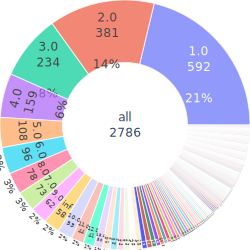

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,hit_rank,gold_doc,gold_doc_score,pred_doc,pred_doc_score,gold_doc_len,pred_doc_len
2436,test2436,where is connective tissue found in the body,[doc84054],{'doc84054': {'text': 'Connective tissue (CT) ...,"{'len': 1000, 'max': 0.7568785548210144, 'min'...",{'doc84054': 0.7568785548210144},"{'doc84054': 0.7568785548210144, 'doc84060': 0...",{'doc84054': {'text': 'Connective tissue (CT) ...,1.0,Connective tissue Connective tissue (CT) is on...,0.756879,Connective tissue Connective tissue (CT) is on...,0.756879,114,114
1092,test1092,what do the stars on the dc flag mean,[doc38193],"{'doc38193': {'text': 'The flag of Washington,...","{'len': 1000, 'max': 0.7301627993583679, 'min'...",{'doc38193': 0.7301627993583679},"{'doc38193': 0.7301627993583679, 'doc2267563':...","{'doc38193': {'text': 'The flag of Washington,...",1.0,"Flag of Washington, D.C. The flag of Washingto...",0.730163,"Flag of Washington, D.C. The flag of Washingto...",0.730163,75,75
1089,test1089,who played anna in once upon a time,[doc38001],{'doc38001': {'text': 'Elizabeth Dean Lail[1] ...,"{'len': 1000, 'max': 0.7622602581977844, 'min'...",{'doc38001': 0.7622602581977844},"{'doc38001': 0.7622602581977844, 'doc408902': ...",{'doc38001': {'text': 'Elizabeth Dean Lail[1] ...,1.0,Elizabeth Lail Elizabeth Dean Lail[1] (born Ma...,0.762260,Elizabeth Lail Elizabeth Dean Lail[1] (born Ma...,0.762260,34,34
590,test590,what type of joint connects the incus with the...,[doc21208],{'doc21208': {'text': 'Incudomalleolar joint (...,"{'len': 1000, 'max': 0.6476312875747681, 'min'...",{'doc21208': 0.6476312875747681},"{'doc21208': 0.6476312875747681, 'doc2412398':...",{'doc21208': {'text': 'Incudomalleolar joint (...,1.0,Incudomalleolar joint Incudomalleolar joint (m...,0.647631,Incudomalleolar joint Incudomalleolar joint (m...,0.647631,70,70
2596,test2596,who played ben stone son on law and order,[doc88901],"{'doc88901': {'text': 'Benjamin ""Ben"" Stone is...","{'len': 1000, 'max': 0.7576804757118225, 'min'...",{'doc88901': 0.7576804757118225},"{'doc88901': 0.7576804757118225, 'doc88910': 0...","{'doc88901': {'text': 'Benjamin ""Ben"" Stone is...",1.0,Benjamin Stone (Law & Order character) Benjami...,0.757680,Benjamin Stone (Law & Order character) Benjami...,0.757680,49,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,test2618,who plays samson in the bible tv series,[doc89755],{'doc89755': {'text': 'Anozie played small rol...,"{'len': 1000, 'max': 0.7472128868103027, 'min'...",{'doc89755': None},"{'doc713562': 0.7472128868103027, 'doc860718':...",{'doc713562': {'text': 'Samson is a 2018 bibli...,inf,Nonso Anozie Anozie played small roles as Thin...,NaN,Samson (2018 film) Samson is a 2018 biblical d...,0.747213,157,58
1033,test1033,where is the movie wonder supposed to take place,[doc36267],"{'doc36267': {'text': 'August ""Auggie"" Pullman...","{'len': 1000, 'max': 0.6541545391082764, 'min'...",{'doc36267': None},"{'doc36278': 0.6541545391082764, 'doc74881': 0...",{'doc36278': {'text': 'Wonder was scheduled to...,inf,"Wonder (film) August ""Auggie"" Pullman is a you...",NaN,Wonder (film) Wonder was scheduled to be relea...,0.654155,115,56
1485,test1485,who wrote the first declaration of human rights,[doc52806],{'doc52806': {'text': 'The Cylinder's text has...,"{'len': 1000, 'max': 0.7345739006996155, 'min'...",{'doc52806': None},"{'doc305460': 0.7345739006996155, 'doc2364000'...","{'doc305460': {'text': 'The Declaration, toget...",inf,Cyrus Cylinder The Cylinder's text has traditi...,NaN,Declaration of the Rights of the Man and of th...,0.734574,241,44
1235,test1235,who sings i just want to use your love tonight,[doc43833],"{'doc43833': {'text': '""Your Love"" is a song b...","{'len': 1000, 'max': 0.6143867373466492, 'min'...",{'doc43833': None},"{'doc1539127': 0.6143867373466492, 'doc1539124...","{'doc1539127': {'text': 'Maxi CD single', 'tit...",inf,"Your L

In [3]:
### df filtering
import plotly.express as px

def find_index(l, idx, not_found_value=np.inf):
    try:
        return l.index(idx)
    except:
        return not_found_value

### FILTER MULTI GOLD DOCS
print("Total:", len(df_raw))
df = df_raw.loc[df_raw["gold_docs"].str.len() == 1, :].copy()
print("Total:", len(df))

### COMPUTE HIT RANK
df["hit_rank"] = df.apply(lambda row: min([find_index(list(row["scores_1000"].keys()), doc_id) + 1 for doc_id in row["gold_docs"]]), axis=1)
# df["hit_rank"].hist(figsize=(8, 4), bins=50)

dfc = df.copy(); dfc["hit_rank"] = dfc["hit_rank"].astype(str);
fig = px.sunburst(dfc, path=[px.Constant("all"), 'hit_rank'], width=250, height=250)
fig.update_traces(textinfo='label+percent entry+value')
fig.update_layout(margin={'t':0,'l':0,'b':0,'r':0})
fig.show("svg")

### Prepare Docs (title+text)
df["gold_doc"] = df["gold_docs_text"].apply(lambda x: list(x.items())[0][1])
df["gold_doc"] = df["gold_doc"].apply(lambda x: x["title"] + " " + x["text"])
df["gold_doc_score"] = df["scores_gold"].apply(lambda x: list(x.items())[0][1])
df["pred_doc"] = df["predicted_docs_text_10"].apply(lambda x: list(x.items())[0][1])
df["pred_doc"] = df["pred_doc"].apply(lambda x: x["title"] + " " + x["text"])
df["pred_doc_score"] = df["scores_1000"].apply(lambda x: list(x.items())[0][1])

df["gold_doc_len"] = df["gold_doc"].str.split().apply(len)
df["pred_doc_len"] = df["pred_doc"].str.split().apply(len)

df.sort_values("hit_rank")

# DecompX

In [4]:
DATASET = df.attrs["dataset"]
MODEL = df.attrs["model"]  # 'facebook/contriever-msmarco'  # Only BERT or RoBERTa
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIGS = {
    "DecompX":
        DecompXConfig(
            include_biases=True,
            bias_decomp_type="absdot",
            include_LN1=True,
            include_FFN=True,
            FFN_approx_type="GeLU_ZO",
            include_LN2=True,
            aggregation="vector",
            include_classifier_w_pooler=True,
            tanh_approx_type="ZO",
            output_all_layers=True,
            output_attention=None,
            output_res1=None,
            output_LN1=None,
            output_FFN=None,
            output_res2=None,
            output_encoder=None,
            output_aggregated="vector",  # Changed
            output_pooler="norm",
            output_classifier=True,
        ),
}

def load_model_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_config = AutoConfig.from_pretrained(model_name)
    if type(model_config) is transformers.models.roberta.configuration_roberta.RobertaConfig:
        model = RobertaModel.from_pretrained(model_name)
    elif type(model_config) is transformers.models.bert.configuration_bert.BertConfig:
        model = BertModel.from_pretrained(model_name)
    else:
        raise Exception(f"Not implemented model: {model_name}")
    model.to(DEVICE)
    return model, tokenizer

model, tokenizer = load_model_tokenizer(MODEL)

/local1/mohsenfayyaz/anaconda3/envs/beir-env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [10]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib

def print_importance(importance, tokenized_text, discrete=False, prefix=""):
    """
    importance: (sent_len)
    """
    assert len(importance) == len(tokenized_text)
    importance = importance / np.abs(importance).max() / 1.0  # Normalize
    if discrete:
        importance = np.argsort(np.argsort(importance)) / len(importance) / 1.6

    html = "<pre style='line-height: 28px; display: flex; flex-flow: row wrap;'>"+prefix
    for i in range(len(tokenized_text)):
        # if importance[i] > 0:
        #     rgba = plt.get_cmap('Reds')(importance[i] * .7)   # Wistia
        # else:
        #     rgba = plt.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
        rgba = plt.get_cmap('coolwarm')((importance[i] + 1) / 2)
        text_color = "color: rgba(255, 255, 255, 1.0); " if np.abs(importance[i]) > 1 else "color: rgba(10, 10, 10, 1.0); "
        color = f"background-color: rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]}); " + text_color
        html += (f"<div style='"
                 f"{color}"
                 f"border-radius: 5px; padding: 2px; margin: 1px;"
                 f"font-weight: {int(800)};"
                 "width: fit-content; display: flex;"
                 "'>")
        html += tokenized_text[i].replace('<', "[").replace(">", "]")
        html += "</div> "
        if tokenized_text[i] in ["hypothesis,", "hold.", '"contradiction"']:
            html += '<br>'
    return html

def html_wrapper(htmls, desc="text", legend="?"):
    html = ""
    head = """
    <head>
    <style>
        @media print {
            -webkit-print-color-adjust: exact;
        }
        fieldset {
            max-width: 1000px; padding: 8px; border-radius: 20px; border: 3px solid rgb(15, 200, 200); background: white; color: black;
        }
        legend {
            margin-left: 10px; padding: 7px; padding-left: 20px; padding-right: 20px; border: 2px solid rgb(15, 200, 200);
            border-radius: 20px; background: white;
            /*font-family: Arial !important;*/
            font-weight: 600;
        }
        table tr td {
            white-space: nowrap; padding: 5px; color: black;
        }
    </style>
    </head>
    """
    html += head
    html += f"""
        <fieldset>
            <legend>{legend}</legend>
            <table style='width: 1000px; font-weight: 600;'>
            """
    for i in range(len(htmls)):
        html += """
        <tr>
        """
        html += f"<td style='text-align: center; width: 100px;'>{desc}:</td><td>"
        html += htmls[i]
        html += "</td></tr>"
    html += "</table>"
    return html

/local1/mohsenfayyaz/anaconda3/envs/beir-env/lib/python3.11/site-packages/transformers/modeling_utils.py:1101: FutureWarning:

The `device` argument is deprecated and will be removed in v5 of Transformers.



torch.Size([1, 12, 768])
torch.Size([1, 137, 768])
torch.Size([1, 128, 768])


Query:,[CLS] when did the animal rights movement began in the us [SEP]


Gold Doc:


Pred Doc:


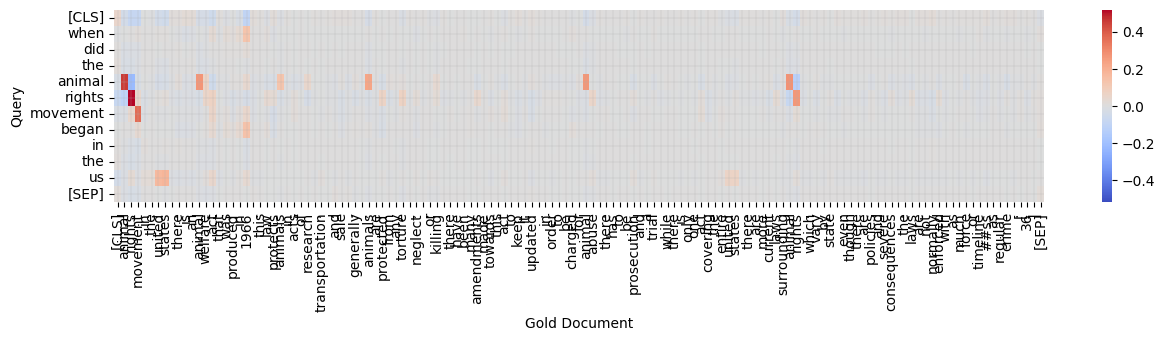

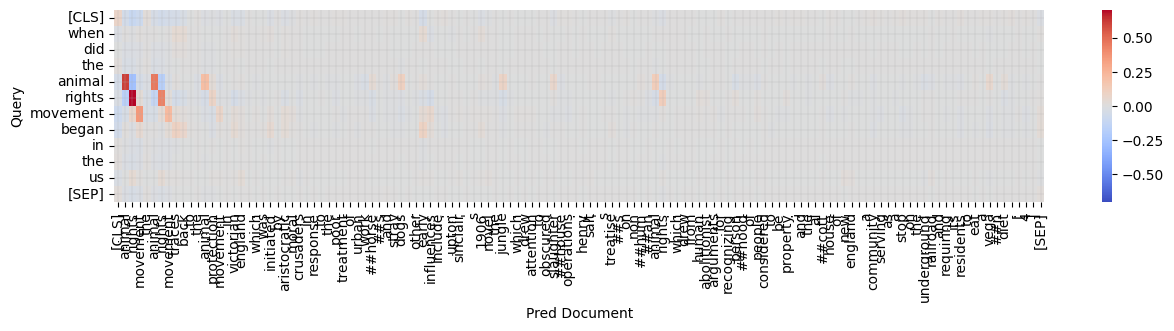

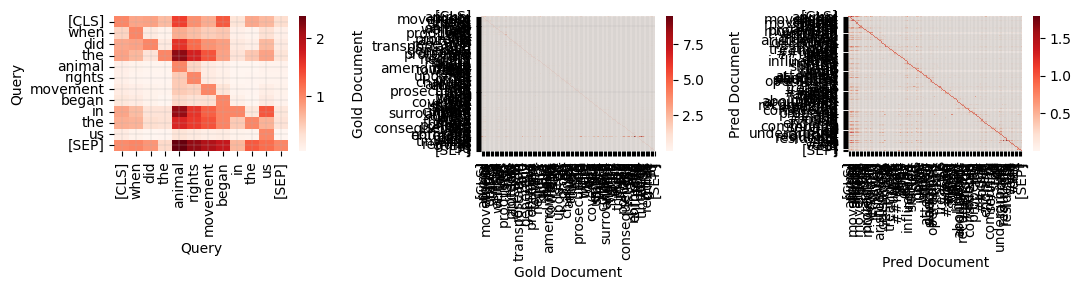

In [16]:
def run_decompx(text):
    inputs = tokenizer([text], padding=True, truncation=True, return_tensors='pt')
    input_ids = inputs["input_ids"]
    inputs.to(model.device)
    with torch.no_grad():
        last_hidden_states, pooler_output, hidden_states, decompx_last_layer_outputs, decompx_all_layers_outputs = model(
            **inputs,
            output_attentions=False,
            return_dict=False,
            output_hidden_states=True,
            decompx_config=CONFIGS["DecompX"]
        )
        ### decompx_last_layer_outputs.aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim] ###
        ### last_hidden_states ~ [1, 70, 768] ~ [batch, seq_len, emb_dim]
        print(last_hidden_states.shape)  # 
        mean_pooled = last_hidden_states[0].mean(dim=0)
        decompx_last_layer_mean = decompx_last_layer_outputs.aggregated[0][0].mean(dim=(0))  # Mean over DecompX similar to the retriever [seq_len, emb_dim]
        tokens_dot_scores = torch.einsum("ij,j->i", decompx_last_layer_mean, mean_pooled)  # [seq_len]
        ranking = torch.argsort(tokens_dot_scores, descending=True).cpu().numpy()
    return {
        "tokens": tokenizer.convert_ids_to_tokens(input_ids[0]),  # [seq_len]
        "tokens_dot_scores": tokens_dot_scores.cpu(),  # [seq_len]  (Dot score with mean)
        "decompx_last_layer_outputs": decompx_last_layer_outputs,  # .aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim]
        "decompx_last_layer_mean": decompx_last_layer_mean.cpu(),  # [seq_len, emb_dim]
    }

def plot_demo(idx):
    ### RUN DECOMPX ON QUERY AND DOC
    query = run_decompx(df.loc[idx]["query"])
    gold_doc = run_decompx(df.loc[idx]["gold_doc"])
    pred_doc = run_decompx(df.loc[idx]["pred_doc"])
    
    ### PLOT MEAN DOT IMPORTANCE
    htmls = [print_importance(query["tokens_dot_scores"], query["tokens"])]
    final_html = html_wrapper(htmls, "Query", f"{DATASET}, {MODEL}, idx={idx}")
    display(HTML(final_html))
    htmls = [print_importance(gold_doc["tokens_dot_scores"], gold_doc["tokens"])]
    final_html = html_wrapper(htmls, "Gold Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['gold_doc_score']}, hit_rank={df.loc[idx]['hit_rank']}")
    display(HTML(final_html))
    htmls = [print_importance(pred_doc["tokens_dot_scores"], pred_doc["tokens"])]
    final_html = html_wrapper(htmls, "Pred Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['pred_doc_score']}")
    display(HTML(final_html))
    
    ### PLOT CROSS DOT IMPORTANCE
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_qd_heatmap(query_tokens, query_decomposed, doc_tokens, doc_decomposed, xlabel="Doc", ylabel="Query"):
        with torch.no_grad():
            qd_scores = torch.einsum("id,jd->ij", query_decomposed, doc_decomposed).cpu().numpy()
        plt.figure(figsize=(15, 2.5))  # 30 for debug
        heatmap(qd_scores, cmap=plt.get_cmap('coolwarm'), vmin=-np.max(np.abs(qd_scores)), vmax=np.max(np.abs(qd_scores)))
        plt.xticks(np.arange(len(doc_tokens))+0.5, doc_tokens, rotation='vertical')
        plt.yticks(np.arange(len(query_tokens))+0.5, query_tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.show()
    
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], gold_doc["tokens"], gold_doc["decompx_last_layer_mean"], "Gold Document")
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], pred_doc["tokens"], pred_doc["decompx_last_layer_mean"], "Pred Document")
    
    
    ### PLOT SELF DECOMPX BLOCKS
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_decompx_heatmap(tokens, decompx_last_layer_outputs, label="?"):
        norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
        heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)), cmap=plt.get_cmap('Reds'))
        plt.xticks(np.arange(len(tokens))+0.5, tokens, rotation='vertical')
        plt.yticks(np.arange(len(tokens))+0.5, tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(label); plt.ylabel(label)
    
    plt.figure(figsize=(11, 3))
    plt.subplot(1, 3, 1); plot_decompx_heatmap(query["tokens"], query["decompx_last_layer_outputs"], "Query")
    plt.subplot(1, 3, 2); plot_decompx_heatmap(gold_doc["tokens"], gold_doc["decompx_last_layer_outputs"], "Gold Document")
    plt.subplot(1, 3, 3); plot_decompx_heatmap(pred_doc["tokens"], pred_doc["decompx_last_layer_outputs"], "Pred Document")
    plt.tight_layout()

plot_demo(idx=1673)  # 329

# Playground

In [ ]:
rank_ranges = [[2, 5], [6, 20], [21, np.inf]]

df_err = None
for rank_range in rank_ranges:
    dfc = df.copy()
    dfc = dfc[(dfc["hit_rank"] >= rank_range[0]) & (dfc["hit_rank"] <= rank_range[1])].sample(20, random_state=0).sort_index().sort_values("hit_rank")
    df_err = dfc.copy() if df_err is None else pd.concat([df_err, dfc.copy()])
df_err[["query_id", "query", "gold_docs", "hit_rank", "gold_doc", "gold_doc_score", "pred_doc", "pred_doc_score", "gold_doc_len", "pred_doc_len"]].to_excel("temp.xlsx")
df_err

In [ ]:
plot_demo(idx=127)

In [ ]:
### DOC LEN STATS
plt.style.use("ggplot")

### SCATTER PLOT
dfc2 = dfc.copy(); dfc2.loc[dfc2["hit_rank"] > 1e5, "hit_rank"] = 1200;
plt.figure(figsize=(6, 4))
plt.scatter(dfc2["hit_rank"], dfc2["gold_doc_len"], color="orange", label="Gold Doc", alpha=0.5, s=1)
plt.scatter(dfc2["hit_rank"], dfc2["pred_doc_len"], color="blue", label="Pred Doc", alpha=0.5, s=1)
plt.legend(); plt.xlabel("Hit Rank"); plt.ylabel("Doc Words")
plt.show()

### LEN DIFF PLOT
dfc2["gold-doc"] = dfc2.apply(lambda row: row["gold_doc_len"] - row["pred_doc_len"], axis=1)
dfc2 = dfc2.fillna(0)
plt.figure(figsize=(6, 4))
dfc2.plot.scatter(x="hit_rank", y="gold-doc", alpha=0.8, s=2, figsize=(6, 4))
# plt.scatter(dfc2["hit_rank"], dfc2["gold-doc"], color="orange", label="Gold Doc", alpha=0.5, s=1)
# plt.legend(); plt.xlabel("Hit Rank"); plt.ylabel("gold-doc")
dfc2.plot.scatter(x="pred_doc_score", y="pred_doc_len", alpha=0.8, s=2, figsize=(6, 4))
plt.xlim(0,1)
dfc2.plot.scatter(x="gold_doc_score", y="gold_doc_len", alpha=0.8, s=2, figsize=(6, 4))
plt.xlim(0,1)

### BOX PLOT
plt.figure(figsize=(6, 4))
dfc2.boxplot(column=['gold_doc_len', 'pred_doc_len'])
plt.ylabel("Doc Words")
plt.show()
# dfc2.plot.scatter(x="hit_rank", y="gold_doc_len", label='aapl', color=['orange', 'green'], alpha=0.7, s=0.7)
# dfc2.plot.scatter(x="hit_rank", y="pred_doc_len", alpha=0.7, s=0.7)

In [ ]:
# CLS ATTN
htmls = [print_importance(norm_heatmap[0], tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
from seaborn import heatmap

norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)))

In [ ]:
a = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3.0]])
a

In [ ]:
a.mean(dim=0)

In [ ]:
dot_scores